In [1]:
import time
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('recsys_retail_train.csv')
data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    return recs.tolist()

In [5]:
def weighted_random_recommendation(data, target_for_freq='item_id', n=5):
    """Случайные рекоммендации"""
    
    # В данном алгоритме товары отбираются на основании антипопулярности товаров.
    # Чем меньше товар встречается, тем больше его вес(чтобы случайно рекомендовать менее популярные товары)
    #   (чтобы 

    dict_ = {}
    len_data = len(data)
    for item, counts in zip(data[target_for_freq].value_counts().index, data_train[target_for_freq].value_counts()):
        dict_[item] = np.log(len_data / counts) * (1 - (counts / len_data ))
    
    tmp_data = pd.DataFrame(data=dict_.items(), columns=['item', 'weight'])
    
    tmp_data['weight'] = tmp_data['weight'] / tmp_data['weight'].sum()
        
    items = np.array(tmp_data['item'].unique())
    
    recs = np.random.choice(items, size=n*2, replace=False)
    
    #ascending=False -> антипопулярность, ascending=True -> популярность
#     display(tmp_data.loc[tmp_data['item'].isin(recs)].sort_values(by='weight', ascending=False))
    recs_final = tmp_data.loc[tmp_data['item'].isin(recs)].sort_values(by='weight', ascending=False)['item'][:n]
    
    return recs_final.tolist()

In [6]:
weighted_random_recommendation(data_train, target_for_freq='item_id', n=5)

[13911562, 6555328, 80571, 1587022, 12756860]

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [7]:
result = pd.read_csv('predictions_basic.csv', sep=',')
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[1120297, 12672919, 865377, 14074566, 1073212]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[12985723, 13511470, 976405, 6920289, 953154]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[1082185, 1098066, 6534178, 1127831, 1068719]"
2,6,[ 920308 926804 946489 1006718 1017061 ...,"[867846, 223642, 873201, 1054917, 13190151]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 878996]","[1082185, 1029743, 6534178, 1127831, 995785]"
3,7,[ 840386 889774 898068 909714 929067 ...,"[2145112, 7167902, 78446, 1089157, 1114786]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 999999, 1127831, 961554]","[1082185, 981760, 1127831, 999999, 961554]","[1082185, 1029743, 1127831, 995785, 1044078]"
4,8,[ 835098 872137 910439 924610 992977 ...,"[827643, 2581354, 1207494, 1105074, 1765862]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 1098066]","[1082185, 981760, 999999, 1098066, 826249]","[1082185, 981760, 999999, 1098066, 826249]","[1082185, 1029743, 1098066, 6534178, 1127831]"


In [8]:
result['actual'] = [set(ii.replace('[', '').replace(']', '').replace('\n', '').split(' ')) for ii in result['actual']]

result['tmp'] = [ii.discard('') for ii in result['actual']]
result.drop(columns='tmp', inplace=True)

result['actual'] = [list(ii) for ii in result['actual']]

result['actual'] = [list(map(int, ii)) for ii in result['actual']]

type(result['actual'][0][0])

int

In [9]:
listt = ['random_recommendation', 'popular_recommendation', 'itemitem', 'cosine', 'tfidf', 'own_purchases']

for col in listt:
    result[col] = [ set(ii.replace('[', '').replace(']', '').replace(' ', '').split(',')) for ii in result[col] ]

    result['tmp'] = [ii.discard('') for ii in result[col]]
    result.drop(columns='tmp', inplace=True)
    
    result[col] = [list(ii) for ii in result[col]]
    
    result[col] = [list(map(int, ii)) for ii in result[col]]

    print(type(result[col][0][0]))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [10]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[943316, 1069733, 13876341, 15830875, 1131115,...","[1120297, 865377, 12672919, 14074566, 1073212]","[6533889, 6534178, 1029743, 1082185, 6534166]","[981760, 999999, 995242, 1082185, 1127831]","[1098066, 981760, 999999, 1082185, 1127831]","[1098066, 981760, 999999, 1082185, 1127831]","[995785, 1029743, 1082185, 1004906, 1081177]"
1,3,"[920626, 878302, 913202, 958154, 851057, 99489...","[6920289, 976405, 12985723, 13511470, 953154]","[6533889, 6534178, 1029743, 1082185, 6534166]","[1098066, 981760, 999999, 1082185, 995242]","[1098066, 981760, 999999, 826249, 1082185]","[1098066, 981760, 999999, 826249, 1082185]","[1098066, 1068719, 6534178, 1082185, 1127831]"


In [12]:
resultcopy = result.copy()
resultcopy.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[943316, 1069733, 13876341, 15830875, 1131115,...","[1120297, 865377, 12672919, 14074566, 1073212]","[6533889, 6534178, 1029743, 1082185, 6534166]","[981760, 999999, 995242, 1082185, 1127831]","[1098066, 981760, 999999, 1082185, 1127831]","[1098066, 981760, 999999, 1082185, 1127831]","[995785, 1029743, 1082185, 1004906, 1081177]"
1,3,"[920626, 878302, 913202, 958154, 851057, 99489...","[6920289, 976405, 12985723, 13511470, 953154]","[6533889, 6534178, 1029743, 1082185, 6534166]","[1098066, 981760, 999999, 1082185, 995242]","[1098066, 981760, 999999, 826249, 1082185]","[1098066, 981760, 999999, 826249, 1082185]","[1098066, 1068719, 6534178, 1082185, 1127831]"
2,6,"[874149, 820165, 1015296, 1100691, 12731467, 1...","[873201, 223642, 1054917, 13190151, 867846]","[6533889, 6534178, 1029743, 1082185, 6534166]","[981760, 999999, 995242, 1082185, 1127831]","[1098066, 981760, 999999, 1082185, 1127831]","[981760, 999999, 1082185, 1127831, 878996]","[6534178, 995785, 1029743, 1082185, 1127831]"
3,7,"[836281, 822346, 10285022, 994928, 839747, 559...","[1114786, 78446, 1089157, 7167902, 2145112]","[6533889, 6534178, 1029743, 1082185, 6534166]","[981760, 999999, 995242, 1082185, 1127831]","[981760, 999999, 961554, 1082185, 1127831]","[981760, 999999, 961554, 1082185, 1127831]","[995785, 1029743, 1044078, 1082185, 1127831]"
4,8,"[1076769, 969932, 919963, 858001, 950977, 1051...","[1105074, 1207494, 2581354, 827643, 1765862]","[6533889, 6534178, 1029743, 1082185, 6534166]","[1098066, 981760, 999999, 1082185, 1127831]","[1098066, 981760, 999999, 826249, 1082185]","[1098066, 981760, 999999, 826249, 1082185]","[1098066, 6534178, 1029743, 1082185, 1127831]"


In [13]:
data_for_rand_w = data_train.loc[data_train['user_id'].isin(result.user_id.values.tolist())][['user_id', 'item_id']]
data_for_rand_w

,user_id,item_id
0,2375,1004906
1,2375,1033142
2,2375,1036325
3,2375,1082185
4,2375,8160430
...,...,...
2282320,222,1120741
2282321,462,993339
2282322,462,995242
2282323,462,10180324


In [14]:
%%time
resultcopy['random_w'] = resultcopy['user_id'].apply(
    lambda x: weighted_random_recommendation(data_for_rand_w, target_for_freq='item_id', n=5))


Wall time: 14min 1s


In [15]:
resultcopy.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,random_w
0,1,"[943316, 1069733, 13876341, 15830875, 1131115,...","[1120297, 865377, 12672919, 14074566, 1073212]","[6533889, 6534178, 1029743, 1082185, 6534166]","[981760, 999999, 995242, 1082185, 1127831]","[1098066, 981760, 999999, 1082185, 1127831]","[1098066, 981760, 999999, 1082185, 1127831]","[995785, 1029743, 1082185, 1004906, 1081177]","[2215639, 1003230, 1022675, 10149896, 1005673]"
1,3,"[920626, 878302, 913202, 958154, 851057, 99489...","[6920289, 976405, 12985723, 13511470, 953154]","[6533889, 6534178, 1029743, 1082185, 6534166]","[1098066, 981760, 999999, 1082185, 995242]","[1098066, 981760, 999999, 826249, 1082185]","[1098066, 981760, 999999, 826249, 1082185]","[1098066, 1068719, 6534178, 1082185, 1127831]","[12428632, 14024802, 5791664, 8158519, 6961522]"


In [16]:
# your_code
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [17]:
for col in tqdm(listt +['random_w']):
    for user in result.user_id.values:
        rec = resultcopy.loc[resultcopy['user_id'] == user, col].values[0]
        
        bought = resultcopy.loc[resultcopy['user_id'] == user, 'actual'].values[0]
                                
        resultcopy.loc[resultcopy['user_id'] == user, col] = precision_at_k(rec,
                                                                            bought,
                                                                            k=5)


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:09<00:03,  1.94s/it]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.94s/it]


In [18]:
resultcopy

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,random_w
0,1,"[943316, 1069733, 13876341, 15830875, 1131115,...",0.0,0.2,0.4,0.2,0.2,0.4,0.0
1,3,"[920626, 878302, 913202, 958154, 851057, 99489...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,"[874149, 820165, 1015296, 1100691, 12731467, 1...",0.0,0.0,0.2,0.0,0.0,0.0,0.0
3,7,"[836281, 822346, 10285022, 994928, 839747, 559...",0.0,0.2,0.2,0.4,0.4,0.2,0.0
4,8,"[1076769, 969932, 919963, 858001, 950977, 1051...",0.0,0.4,0.2,0.2,0.2,0.4,0.0
...,...,...,...,...,...,...,...,...,...
2037,2496,[6534178],0.0,0.2,0.0,0.0,0.0,0.2,0.0
2038,2497,"[968057, 1128647, 6534178, 938463, 911470, 952...",0.0,0.2,0.0,0.0,0.0,0.2,0.0
2039,2498,"[972437, 943316, 933389, 73048, 16208725, 1036...",0.0,0.2,0.2,0.2,0.2,0.2,0.0
2040,2499,"[1060872, 958137, 10150194, 914190, 951590, 90...",0.0,0.0,0.0,0.0,0.0,0.0,0.0


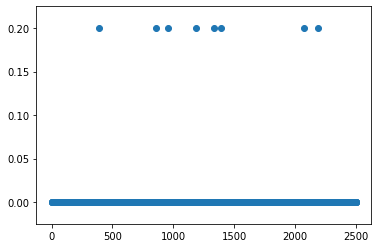

In [19]:
plt.scatter(resultcopy.user_id, resultcopy.random_recommendation
       )

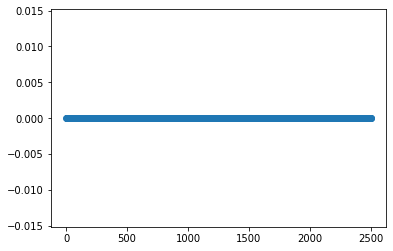

In [20]:
plt.scatter(resultcopy.user_id, resultcopy.random_w
       )

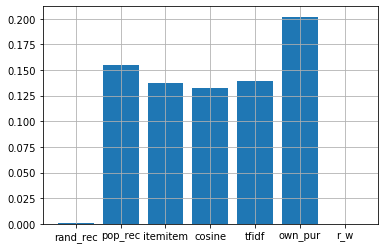

In [21]:
plt.bar([1,2,3,4,5,6,7],
        [
    resultcopy.random_recommendation.mean(),
    resultcopy.popular_recommendation.mean(),
            resultcopy.itemitem.mean(),
            resultcopy.cosine.mean(),
            resultcopy.tfidf.mean(),
            resultcopy.own_purchases.mean(),
            resultcopy.random_w.mean()
        ], tick_label=['rand_rec',
                       'pop_rec',
                       'itemitem',
                       'cosine',
                       'tfidf',
                       'own_pur',
                      'r_w']
       )
plt.grid()

#### Лучший алгоритм при оценке Precision@5 на основании арифметической средней это own_purchases, а также чуть лучше остальныйх показал себя алгоритм popular_recommendation


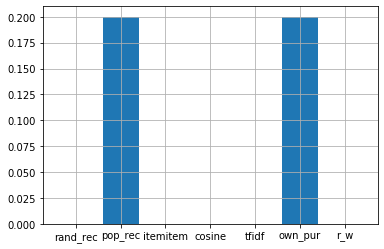

In [22]:
plt.bar([1,2,3,4,5,6,7],
        [
    resultcopy.random_recommendation.median(),
    resultcopy.popular_recommendation.median(),
            resultcopy.itemitem.median(),
            resultcopy.cosine.median(),
            resultcopy.tfidf.median(),
            resultcopy.own_purchases.median(),
            resultcopy.random_w.median()
        ], tick_label=['rand_rec',
                       'pop_rec',
                       'itemitem',
                       'cosine',
                       'tfidf',
                       'own_pur',
                       'r_w']
       )
plt.grid()

In [23]:
resultcopy.random_recommendation.median()

0.0

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [ ]:
# your_code